<div class="alert alert-block alert-danger">
<h2>Deprecation warning: <br>
    Note that further development on this notebook is moving to https://github.com/spacetelescope/jwst-pipeline-notebooks/
    </h1></div>

<img style="float: center;" src='https://github.com/STScI-MIRI/MRS-ExampleNB/raw/main/assets/banner1.png' alt="stsci_logo" width="900px"/> 

<a id="title_ID"></a>
# MIRI MRS Batch Processing Notebook #


**Author**: David Law (AURA Associate Astronomer, MIRI branch), Kirsten Larson (ESA/AURA Astronomer, MIRI branch)
<br>
**Last Updated**: July 15, 2024
<br>
**Pipeline Version**: 1.14.1

The purpose of this notebook is to provide a framework for processing generic MIRI MRS data through all three pipeline stages.  Data is assumed to be located in two Observation folders (science and background) according to paths set up below.  It should not be necessary to edit any cells other than in the 'Configuration' section unless modifying the standard pipeline processing for MIRI MRS.

This example is set up to use observations of the LMC planetary nebula SMP LMC 058 obtained by PID 1523 Observation 3.  This is a point source that uses a standard 4-pt dither in all three grating settings.  It incorporates a dedicated background in Observation 4.  Input data for this notebook can be obtained by downloading the 'uncal' files from MAST and placing them in directories set up below.

This notebook is regularly updated as improvements are made to the pipeline. Find the most up to date version of this notebook at:
https://github.com/STScI-MIRI/MRS-ExampleNB/blob/main/Flight_Notebook1/MRS_FlightNB1.ipynb


Changes:<br>
Sep 1 2022: Add some commentary and example on how to use multicore processing in Detector 1<br>
Sep 12 2022: Disable unnecessary cube/1d spectra production for individual science exposures in Spec 2<br>
Oct 14 2022: Include residual fringe correction in spec2 (note that this will CRASH earlier pipeline versions!<br>
Jun 29 2023: Update to latest 1.11.0 pipeline with photom, outlier detection, and x1d changes, add CRDS path options.  Change to SMP LMC 058 demo.<br>
Oct 11 2023: Update to 1.12.3 pipeline with 1d spectral residual fringe and auto-centroid options, 2d pixel replacement, and a variety of new cube build options.<br>
Nov 17 2023: Incorporate CRDS default parameters for detector1 and spec2<br>
Nov 20 2023: Significant revisions to allow use of associations in spec2, allow choice of pixel-based background subtraction.<br>
Nov 24 2023: Additional comments and plotting examples.<br>
Jan 31 2024: Update to 1.13.4 pipeline, enabling spectral leak correction<br>
Jul 15 2024: Update to 1.14.1 pipeline (Build 10.2), be explicit about use of .run() functionality, turn off CR showers by default

<hr style="border:1px solid gray"> </hr>

1.<font color='white'>-</font>Configuration <a class="anchor" id="intro"></a>
------------------

In [1]:
# Set parameters to be changed here.
# It should not be necessary to edit cells below this in general unless modifying pipeline processing steps.

import sys,os, pdb

# -----------------------------    Set CRDS context and paths   ----------------------------
# CRDS context (if overriding)
#%env CRDS_CONTEXT  jwst_1146.pmap

# Set CRDS paths if not set already in your .bashrc shell configuration
#os.environ['CRDS_PATH'] = "../crds_cache"  #use this path for Workshop
#os.environ['CRDS_PATH']='/Users/kilarson/crds'
os.environ['CRDS_SERVER_URL']='https://jwst-crds.stsci.edu'
# Echo CRDS path in use
print('CRDS local filepath:',os.environ['CRDS_PATH'])
print('CRDS file server:',os.environ['CRDS_SERVER_URL'])

# -----------------------------    Set Directories   ----------------------------

# Point to where the uncalibrated FITS files are from the science observation
input_dir = '/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/'

# Point to where you want the output science results to go
output_dir = '/Users/dlaw/FlightData/APT1523/data/Obs03'

# Point to where the uncalibrated FITS files are from the background observation
# If no background observation, leave this blank
input_bgdir = '/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/'

# Point to where the output background observations should go
# If no background observation, leave this blank
output_bgdir = '/Users/dlaw/FlightData/APT1523/data/Obs04'

# -----------------------------    Set Processing Steps   ----------------------------

# Whether or not to process only data from a given band/channel
# Useful if overriding reference files
# Note BOTH must be set in order to work
use_ch='' # '12' or '34'
use_band='' # 'SHORT', 'MEDIUM', or 'LONG'

# Whether or not to run a given pipeline stage:

# Science processing
dodet1=True
dospec2=True
dospec3=True

# Background processing
dodet1bg=True
dospec2bg=True #needed for Master Background subtraction

# Where should background subtraction using the dedicated backgrounds be done?
# (Note that if using master-background subtraction, backgrounds must be select above to process through spec2)
pixel_bg = False # Pixel-based background subtraction in spec2 (direct pixel subtraction) -Deep background exposures needed to not add noise.
master_bg = True # Master-background subtraction in spec3 (subtract spectrum generated from the backgrounds) -This is the default pipeline setting

# (If none of the above is done, cubes will not be background subtracted.  1d spectra will use local annular background subtraction for point sources)

# If there is no background folder, ensure we don't try to process it
if (input_bgdir == ''):
    dodet1bg=False
    dospec2bg=False



CRDS local filepath: /Users/dlaw/crds_cache/jwst_ops
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

2.<font color='white'>-</font>Imports and setup <a class="anchor" id="intro"></a>
------------------

In [2]:
# Now let's use the entire available screen width for the notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [3]:
# Basic system utilities for interacting with files
#----------------------------------------------General Imports-----------------------------------------------------
import glob
import time
import shutil
import warnings
import zipfile
import urllib.request
# Numpy for doing calculations
import numpy as np

#--------------------------------------------Astropy Imports--------------------------------------------
# Astropy utilities for opening FITS and ASCII files
from astropy.io import fits
from astropy.io import ascii
from astropy.utils.data import download_file
# Astropy utilities for making plots
from astropy.visualization import (LinearStretch, LogStretch, ImageNormalize, ZScaleInterval)

#------------------------------------------------Plotting Imports--------------------------------------------------
# Matplotlib for making plots
import matplotlib.pyplot as plt
from matplotlib import rc

In [4]:
#--------------------------------------JWST Calibration Pipeline Imports-------------------------------------------
# Import the base JWST package
import jwst
import crds

# JWST pipelines (encompassing many steps)
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Spec2Pipeline
from jwst.pipeline import Spec3Pipeline
#from jwst.extract_1d import Extract1dStep     #Extract1D Individual Step

# JWST pipeline utilities
from jwst import datamodels # JWST datamodels
from jwst.associations import asn_from_list as afl # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base # Definition of a Lvl3 association file

from stcal import dqflags # Utilities for working with the data quality (DQ) arrays


#--
print("JWST Calibration Pipeline Version={}".format(jwst.__version__))
print("Current Operational CRDS Context = {}".format(crds.get_default_context()))


2024-07-15 15:53:21,525 - stpipe - WARNING - /var/folders/lg/jw_brb093bl9n39fbgn1cw080001fw/T/ipykernel_14098/3459538792.py:18: DeprecationWarning: dqflags has been moved to stdatamodels.dqflags, please use that instead
2024-07-15 15:53:21,526 - stpipe - WARNING -   from stcal import dqflags # Utilities for working with the data quality (DQ) arrays
2024-07-15 15:53:21,526 - stpipe - WARNING - 


JWST Calibration Pipeline Version=1.14.1
Current Operational CRDS Context = jwst_1252.pmap


In [5]:
# Output subdirectories to keep science data products organized
# Note that the pipeline might complain about this as it is intended to work with everything in a single
# directory, but it nonetheless works fine for the examples given here.
det1_dir = os.path.join(output_dir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_dir = os.path.join(output_dir, 'stage2/') # Spec2 pipeline outputs will go here
spec3_dir = os.path.join(output_dir, 'stage3/') # Spec3 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(spec2_dir):
    os.makedirs(spec2_dir)
if not os.path.exists(spec3_dir):
    os.makedirs(spec3_dir)

In [6]:
# Output subdirectories to keep background data products organized
det1_bgdir = os.path.join(output_bgdir, 'stage1/') # Detector1 pipeline outputs will go here
spec2_bgdir = os.path.join(output_bgdir, 'stage2/') # Spec2 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not create them
if (output_bgdir != ''):
    if not os.path.exists(det1_bgdir):
        os.makedirs(det1_bgdir)
    if not os.path.exists(spec2_bgdir):
        os.makedirs(spec2_bgdir)

In [7]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

3.<font color='white'>-</font>Detector1 Pipeline <a class="anchor" id="det1"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through the Detector1 pipeline to create Lvl2a data products (i.e., uncalibrated slope images).
    
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html
</div>

In [8]:
# First we'll define a function that will call the detector1 pipeline with our desired set of parameters
# We won't enumerate the individual steps
def rundet1(filename, outdir):
    print(filename)
    # Set default configuration from CRDS param reference files
    # -This is required when running the pipeline in a function.
    crds_config = Detector1Pipeline.get_config_from_reference(filename)
    det1 = Detector1Pipeline.from_config_section(crds_config)
    
    det1.output_dir = outdir # Specify where the output should go
    
    # Overrides for whether or not certain steps should be skipped
    #det1.dq_init.skip = False
    #det1.saturation.skip = False
    #det1.firstframe.skip = False
    #det1.lastframe.skip = False
    #det1.reset.skip = False
    #det1.linearity.skip = False
    #det1.rscd.skip = False
    #det1.dark_current.skip = False
    #det1.refpix.skip = False
    #det1.jump.skip = False
    #det1.ramp_fit.skip = False
    #det1.gain_scale.skip = False
    
    # The jump and ramp fitting steps can benefit from multi-core processing, but this is off by default
    # Turn them on here if desired by choosing how many cores to use (quarter, half, or all)
    det1.jump.maximum_cores='half'
    det1.ramp_fit.maximum_cores='half'
    # This next parameter helps with very bright objects and/or very short ramps
    det1.jump.three_group_rejection_threshold=100
    
    # Enable detection of large cosmic ray showers
    # Warning: Can sometimes mask sources for very bright data!
    #det1.jump.find_showers=True
    
    # Bad pixel mask overrides
    #det1.dq_init.override_mask = 'myfile.fits'

    # Saturation overrides
    #et1.saturation.override_saturation = 'myfile.fits'
    
    # Reset overrides
    #det1.reset.override_reset = 'myfile.fits'
        
    # Linearity overrides
    #det1.linearity.override_linearity = 'myfile.fits'

    # RSCD overrides
    #det1.rscd.override_rscd = 'myfile.fits'
        
    # DARK overrides
    #det1.dark_current.override_dark = 'myfile.fits'
        
    # GAIN overrides
    #det1.jump.override_gain = 'myfile.fits'
    #det1.ramp_fit.override_gain = 'myfile.fits'
                
    # READNOISE overrides
    #det1.jump.override_readnoise = 'myfile.fits'
    #det1.ramp_fit.override_readnoise = 'myfile.fits'
        
    det1.save_results = True # Save the final resulting _rate.fits files
    det1.run(filename) # Run the pipeline on an input list of files

In [9]:
# Now let's look for input files of the form *uncal.fits from the science observation
sstring = input_dir + 'jw*mirifu*uncal.fits'
lvl1b_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(lvl1b_files))
    for ii in range(0,len(lvl1b_files)):
        hdu=fits.open(lvl1b_files[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    lvl1b_files=lvl1b_files[indx]

print('Found ' + str(len(lvl1b_files)) + ' science input files')

Found 24 science input files


In [10]:
# Run the pipeline on these input files by a simple loop over our pipeline function
if dodet1:
    for file in lvl1b_files:
        rundet1(file, det1_dir)
else:
    print('Skipping Detector1 processing for SCI data')

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifulong_uncal.fits


2024-07-15 15:53:22,236 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-emicorrstep_0002.asdf
2024-07-15 15:53:22,244 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-jumpstep_0003.asdf
2024-07-15 15:53:22,249 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-detector1pipeline_0005.asdf
2024-07-15 15:53:22,259 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2024-07-15 15:53:22,260 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2024-07-15 15:53:22,260 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2024-07-15 15:53:22,261 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2024-07-15 15:53:22,261 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance cr

2024-07-15 15:53:22,400 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']
2024-07-15 15:53:22,404 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits'.
2024-07-15 15:53:22,404 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 15:53:22,404 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-07-15 15:53:22,405 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jws

2024-07-15 15:53:54,917 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:53:54,927 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:53:55,163 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2024-07-15 15:53:55,213 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifulong_uncal.fits>,).
2024-07-15 15:53:55,223 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-07-15 15:53:55,328 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:53:55,379 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw015230030

2024-07-15 15:54:12,608 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2024-07-15 15:54:12,608 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2024-07-15 15:54:12,609 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2024-07-15 15:54:12,609 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2024-07-15 15:54:12,610 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2024-07-15 15:54:12,610 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2024-07-15 15:54:12,610 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 15:54:12,611 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:54:12,611 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:54:12,612 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
202

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits


2024-07-15 15:54:12,817 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00001_mirifushort_uncal.fits',).
2024-07-15 15:54:12,825 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 15:54:12,916 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 15:54:12,916 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 15:54:12,917 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 15:54:12,917 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 15:54:12,917 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:54:12,917 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 15:54:45,989 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 15:54:46,063 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:54:46,104 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00001_mirifushort_uncal.fits>,).
2024-07-15 15:54:46,113 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 15:54:47,243 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:54:47,254 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:54:47,257 - stpipe.Detector1Pipe

2024-07-15 15:54:58,998 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 15:54:58,999 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:54:58,999 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:54:58,999 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 15:54:59,000 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 15:54:59,000 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 15:54:59,001 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 15:54:59,001 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 15:54:59,002 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 15:54:59,002 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00002_mirifulong_uncal.fits


2024-07-15 15:54:59,170 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 15:54:59,249 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-07-15 15:54:59,250 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2024-07-15 15:54:59,250 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 15:54:59,250 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:54:59,250 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 15:54:59,251 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 15:54:59,251 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 15:55:31,273 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:55:31,315 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifulong_uncal.fits>,).
2024-07-15 15:55:31,324 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 15:55:32,365 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:55:32,383 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:55:32,388 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 15:55:32,388 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 15:55:46,720 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:55:46,721 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:55:46,721 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 15:55:46,721 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 15:55:46,722 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 15:55:46,722 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 15:55:46,723 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 15:55:46,724 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 15:55:46,724 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 15:55:46,892 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00002_mirifushort_uncal.fits


2024-07-15 15:55:46,901 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 15:55:46,989 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 15:55:46,989 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 15:55:46,989 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 15:55:46,990 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:55:46,990 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 15:55:46,990 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 15:55:46,990 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 15:56:19,622 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:56:19,664 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00002_mirifushort_uncal.fits>,).
2024-07-15 15:56:19,672 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 15:56:20,712 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:56:20,730 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:56:20,734 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 15:56:20,734 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 15:56:31,755 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:56:31,755 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:56:31,756 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 15:56:31,756 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 15:56:31,757 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 15:56:31,757 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 15:56:31,758 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 15:56:31,758 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 15:56:31,759 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 15:56:31,912 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00003_mirifulong_uncal.fits


2024-07-15 15:56:31,920 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 15:56:32,000 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-07-15 15:56:32,000 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2024-07-15 15:56:32,000 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 15:56:32,000 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:56:32,001 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 15:56:32,001 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 15:56:32,001 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 15:57:04,049 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:57:04,088 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifulong_uncal.fits>,).
2024-07-15 15:57:04,096 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 15:57:05,140 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:57:05,159 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:57:05,163 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 15:57:05,163 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 15:57:17,766 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:57:17,767 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:57:17,767 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 15:57:17,768 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 15:57:17,768 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 15:57:17,768 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 15:57:17,769 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 15:57:17,770 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 15:57:17,770 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00003_mirifushort_uncal.fits


2024-07-15 15:57:17,922 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00003_mirifushort_uncal.fits',).
2024-07-15 15:57:17,931 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 15:57:18,012 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 15:57:18,012 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 15:57:18,012 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 15:57:18,012 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 15:57:18,013 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:57:18,013 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 15:57:50,514 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 15:57:50,559 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:57:50,599 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00003_mirifushort_uncal.fits>,).
2024-07-15 15:57:50,608 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 15:57:51,647 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:57:51,665 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:57:51,669 - stpipe.Detector1Pipe

2024-07-15 15:58:02,985 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 15:58:02,985 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:58:02,985 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:58:02,986 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 15:58:02,986 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 15:58:02,987 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 15:58:02,987 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 15:58:02,988 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 15:58:02,988 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 15:58:02,989 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00004_mirifulong_uncal.fits


2024-07-15 15:58:03,145 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00004_mirifulong_uncal.fits',).
2024-07-15 15:58:03,153 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: Non

2024-07-15 15:58:03,234 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 15:58:03,234 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-07-15 15:58:03,234 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2024-07-15 15:58:03,234 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 15:58:03,235 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:58:03,235 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 15:58:35,120 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-07-15 15:58:35,170 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:58:35,211 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifulong_uncal.fits>,).
2024-07-15 15:58:35,219 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 15:58:36,267 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:58:36,286 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:58:36,290 - stpipe.Detector1Pipel

2024-07-15 15:58:49,040 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 15:58:49,040 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:58:49,041 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:58:49,041 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 15:58:49,042 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 15:58:49,042 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 15:58:49,042 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 15:58:49,043 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 15:58:49,044 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 15:58:49,044 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03102_00004_mirifushort_uncal.fits


2024-07-15 15:58:49,205 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 15:58:49,285 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 15:58:49,285 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 15:58:49,285 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 15:58:49,285 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:58:49,285 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 15:58:49,286 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 15:58:49,286 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 15:59:21,896 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 15:59:21,937 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03102_00004_mirifushort_uncal.fits>,).
2024-07-15 15:59:21,946 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 15:59:22,976 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:59:22,994 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 15:59:22,998 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 15:59:22,998 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 15:59:34,365 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 15:59:34,365 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 15:59:34,366 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 15:59:34,366 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 15:59:34,367 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 15:59:34,367 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 15:59:34,368 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 15:59:34,368 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 15:59:34,369 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 15:59:34,517 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00001_mirifulong_uncal.fits


2024-07-15 15:59:34,525 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 15:59:34,606 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 15:59:34,606 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2024-07-15 15:59:34,607 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 15:59:34,607 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 15:59:34,607 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 15:59:34,607 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 15:59:34,607 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:00:06,956 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:00:07,000 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifulong_uncal.fits>,).
2024-07-15 16:00:07,009 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:00:08,112 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:00:08,133 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:00:08,137 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:00:08,138 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:00:21,426 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:00:21,427 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:00:21,427 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:00:21,428 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:00:21,429 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:00:21,429 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:00:21,430 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:00:21,431 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:00:21,432 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00001_mirifushort_uncal.fits


2024-07-15 16:00:21,600 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00001_mirifushort_uncal.fits',).
2024-07-15 16:00:21,609 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 16:00:21,703 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:00:21,704 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:00:21,704 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:00:21,704 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:00:21,705 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:00:21,705 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:00:55,641 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 16:00:55,692 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:00:55,741 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00001_mirifushort_uncal.fits>,).
2024-07-15 16:00:55,750 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:00:56,998 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:00:57,020 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:00:57,027 - stpipe.Detector1Pipe

2024-07-15 16:01:10,783 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:01:10,784 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:01:10,784 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:01:10,785 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:01:10,786 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:01:10,786 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:01:10,786 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:01:10,787 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:01:10,788 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:01:10,788 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00002_mirifulong_uncal.fits


2024-07-15 16:01:10,971 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:01:11,064 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:01:11,065 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2024-07-15 16:01:11,065 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:01:11,065 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:01:11,065 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:01:11,066 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:01:11,066 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:01:44,763 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:01:44,821 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifulong_uncal.fits>,).
2024-07-15 16:01:44,831 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:01:46,000 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:01:46,022 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:01:46,029 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:01:46,029 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:01:59,343 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:01:59,343 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:01:59,344 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:01:59,344 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:01:59,344 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:01:59,345 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:01:59,346 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:01:59,347 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:01:59,347 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00002_mirifushort_uncal.fits


2024-07-15 16:01:59,523 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00002_mirifushort_uncal.fits',).
2024-07-15 16:01:59,533 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 16:01:59,627 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:01:59,627 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:01:59,628 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:01:59,628 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:01:59,628 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:01:59,629 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:02:34,282 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 16:02:34,342 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:02:34,398 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00002_mirifushort_uncal.fits>,).
2024-07-15 16:02:34,408 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:02:35,532 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:02:35,555 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:02:35,561 - stpipe.Detector1Pipe

2024-07-15 16:02:46,677 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:02:46,678 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:02:46,678 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:02:46,679 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:02:46,679 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:02:46,680 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:02:46,680 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:02:46,681 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:02:46,681 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:02:46,682 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00003_mirifulong_uncal.fits


2024-07-15 16:02:46,866 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:02:46,961 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:02:46,961 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2024-07-15 16:02:46,962 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:02:46,962 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:02:46,962 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:02:46,963 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:02:46,963 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:03:21,199 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:03:21,253 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifulong_uncal.fits>,).
2024-07-15 16:03:21,263 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:03:22,398 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:03:22,423 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:03:22,428 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:03:22,429 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:03:35,385 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:03:35,385 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:03:35,386 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:03:35,386 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:03:35,387 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:03:35,387 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:03:35,388 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:03:35,388 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:03:35,389 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:03:35,558 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00003_mirifushort_uncal.fits


2024-07-15 16:03:35,568 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:03:35,661 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:03:35,662 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:03:35,662 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:03:35,662 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:03:35,662 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 16:03:35,663 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:03:35,663 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:04:10,925 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:04:10,981 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00003_mirifushort_uncal.fits>,).
2024-07-15 16:04:10,991 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:04:12,139 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:04:12,163 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:04:12,169 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:04:12,169 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 16:04:24,305 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:04:24,306 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:04:24,306 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:04:24,307 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:04:24,307 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:04:24,308 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:04:24,309 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:04:24,310 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:04:24,310 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:04:24,479 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00004_mirifulong_uncal.fits


2024-07-15 16:04:24,491 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:04:24,595 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:04:24,595 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2024-07-15 16:04:24,596 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:04:24,596 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:04:24,596 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:04:24,597 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:04:24,597 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:04:59,099 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:04:59,152 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifulong_uncal.fits>,).
2024-07-15 16:04:59,161 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:05:00,250 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:05:00,271 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:05:00,276 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:05:00,276 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:05:13,916 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:05:13,917 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:05:13,917 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:05:13,918 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:05:13,918 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:05:13,919 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:05:13,919 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:05:13,920 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:05:13,921 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00004_mirifushort_uncal.fits


2024-07-15 16:05:14,104 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03104_00004_mirifushort_uncal.fits',).
2024-07-15 16:05:14,114 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 16:05:14,205 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:05:14,205 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:05:14,205 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:05:14,206 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:05:14,206 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:05:14,206 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:05:50,959 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 16:05:51,019 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:05:51,072 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03104_00004_mirifushort_uncal.fits>,).
2024-07-15 16:05:51,082 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:05:52,220 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:05:52,244 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:05:52,249 - stpipe.Detector1Pipe

2024-07-15 16:06:03,557 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:06:03,557 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:06:03,558 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:06:03,558 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:06:03,559 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:06:03,559 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:06:03,559 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:06:03,560 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:06:03,561 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:06:03,561 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00001_mirifulong_uncal.fits


2024-07-15 16:06:03,736 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:06:03,825 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:06:03,826 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2024-07-15 16:06:03,826 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:06:03,826 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:06:03,826 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:06:03,827 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:06:03,827 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:06:37,576 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:06:37,629 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifulong_uncal.fits>,).
2024-07-15 16:06:37,639 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:06:38,740 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:06:38,759 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:06:38,765 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:06:38,765 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:06:51,996 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:06:51,997 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:06:51,997 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:06:51,998 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:06:51,998 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:06:51,998 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:06:51,999 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:06:52,000 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:06:52,000 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:06:52,171 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00001_mirifushort_uncal.fits


2024-07-15 16:06:52,180 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:06:52,271 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-07-15 16:06:52,271 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:06:52,272 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:06:52,272 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:06:52,272 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 16:06:52,272 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:06:52,273 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:07:27,905 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:07:27,956 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00001_mirifushort_uncal.fits>,).
2024-07-15 16:07:27,965 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:07:29,077 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:07:29,101 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:07:29,106 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:07:29,106 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 16:07:41,264 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:07:41,265 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:07:41,265 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:07:41,265 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:07:41,266 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:07:41,266 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:07:41,267 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:07:41,268 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:07:41,268 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:07:41,446 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00002_mirifulong_uncal.fits


2024-07-15 16:07:41,456 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:07:41,549 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:07:41,549 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2024-07-15 16:07:41,549 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:07:41,550 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:07:41,550 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:07:41,550 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:07:41,550 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:08:16,192 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:08:16,242 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifulong_uncal.fits>,).
2024-07-15 16:08:16,252 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:08:17,349 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:08:17,368 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:08:17,373 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:08:17,374 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:08:29,947 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:08:29,948 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:08:29,948 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:08:29,948 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:08:29,949 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:08:29,949 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:08:29,950 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:08:29,951 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:08:29,951 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:08:30,133 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00002_mirifushort_uncal.fits


2024-07-15 16:08:30,143 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:08:30,239 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-07-15 16:08:30,239 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:08:30,239 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:08:30,240 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:08:30,240 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 16:08:30,240 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:08:30,240 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:09:05,265 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:09:05,322 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00002_mirifushort_uncal.fits>,).
2024-07-15 16:09:05,332 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:09:06,458 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:09:06,482 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:09:06,488 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:09:06,488 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 16:09:17,556 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:09:17,557 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:09:17,557 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:09:17,558 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:09:17,558 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:09:17,559 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:09:17,559 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:09:17,560 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:09:17,560 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:09:17,739 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00003_mirifulong_uncal.fits


2024-07-15 16:09:17,749 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:09:17,843 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:09:17,843 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2024-07-15 16:09:17,843 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:09:17,844 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:09:17,844 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:09:17,844 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:09:17,844 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:09:52,917 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:09:52,974 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifulong_uncal.fits>,).
2024-07-15 16:09:52,984 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:09:54,119 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:09:54,144 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:09:54,149 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:09:54,149 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:10:07,097 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:10:07,097 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:10:07,097 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:10:07,098 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:10:07,098 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:10:07,099 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:10:07,100 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:10:07,100 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:10:07,100 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00003_mirifushort_uncal.fits


2024-07-15 16:10:07,278 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00003_mirifushort_uncal.fits',).
2024-07-15 16:10:07,288 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 16:10:07,380 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:10:07,380 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-07-15 16:10:07,381 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:10:07,381 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:10:07,381 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:10:07,382 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:10:43,071 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 16:10:43,133 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:10:43,189 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00003_mirifushort_uncal.fits>,).
2024-07-15 16:10:43,199 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:10:44,334 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:10:44,358 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:10:44,363 - stpipe.Detector1Pipe

2024-07-15 16:10:55,772 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:10:55,772 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:10:55,773 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:10:55,773 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:10:55,774 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:10:55,774 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:10:55,774 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:10:55,775 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:10:55,776 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:10:55,776 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00004_mirifulong_uncal.fits


2024-07-15 16:10:55,968 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:10:56,060 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:10:56,060 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2024-07-15 16:10:56,061 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:10:56,061 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:10:56,061 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:10:56,062 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:10:56,062 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:11:30,563 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:11:30,618 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifulong_uncal.fits>,).
2024-07-15 16:11:30,629 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:11:31,785 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:11:31,807 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:11:31,812 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:11:31,813 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:11:44,970 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:11:44,970 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:11:44,971 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:11:44,971 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:11:44,971 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:11:44,972 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:11:44,973 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:11:44,973 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:11:44,974 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00004_mirifushort_uncal.fits


2024-07-15 16:11:45,160 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/uncal/jw01523003001_03106_00004_mirifushort_uncal.fits',).
2024-07-15 16:11:45,171 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 16:11:45,265 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:11:45,266 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-07-15 16:11:45,266 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:11:45,266 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:11:45,267 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:11:45,267 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:12:20,396 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 16:12:20,454 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:12:20,507 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523003001_03106_00004_mirifushort_uncal.fits>,).
2024-07-15 16:12:20,517 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:12:21,610 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:12:21,629 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:12:21,634 - stpipe.Detector1Pipe

In [11]:
# Now let's look for input files of the form *uncal.fits from the background observation
sstring = input_bgdir + 'jw*mirifu*uncal.fits'

lvl1b_files = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(lvl1b_files))
    for ii in range(0,len(lvl1b_files)):
        hdu=fits.open(lvl1b_files[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    lvl1b_files=lvl1b_files[indx]

print('Found ' + str(len(lvl1b_files)) + ' background input files')

Found 12 background input files


In [12]:
# Run the pipeline on these input files by a simple loop over our pipeline function
if dodet1bg:
    for file in lvl1b_files:
        rundet1(file, det1_bgdir)
else:
    print('Skipping Detector1 processing for BG data')

2024-07-15 16:12:33,160 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-emicorrstep_0002.asdf
2024-07-15 16:12:33,168 - stpipe - INFO - PARS-JUMPSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-jumpstep_0003.asdf
2024-07-15 16:12:33,173 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-detector1pipeline_0005.asdf
2024-07-15 16:12:33,183 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2024-07-15 16:12:33,183 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2024-07-15 16:12:33,184 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2024-07-15 16:12:33,184 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.
2024-07-15 16:12:33,185 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance cr

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00001_mirifulong_uncal.fits


2024-07-15 16:12:33,374 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00001_mirifulong_uncal.fits',).
2024-07-15 16:12:33,383 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: Non

2024-07-15 16:12:33,482 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:12:33,482 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-07-15 16:12:33,482 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2024-07-15 16:12:33,483 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:12:33,483 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:12:33,483 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:13:08,645 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-07-15 16:13:08,702 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:13:08,756 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifulong_uncal.fits>,).
2024-07-15 16:13:08,765 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:13:09,871 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:13:09,890 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:13:09,895 - stpipe.Detector1Pipel

2024-07-15 16:13:22,042 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:13:22,043 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:13:22,043 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:13:22,044 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:13:22,044 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:13:22,044 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:13:22,045 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:13:22,046 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:13:22,046 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:13:22,046 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00001_mirifushort_uncal.fits


2024-07-15 16:13:22,229 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:13:22,325 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:13:22,325 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:13:22,325 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:13:22,326 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:13:22,326 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 16:13:22,326 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:13:22,326 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:13:57,917 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:13:57,971 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00001_mirifushort_uncal.fits>,).
2024-07-15 16:13:57,981 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:13:59,113 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:13:59,136 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:13:59,142 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:13:59,142 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 16:14:12,929 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:14:12,930 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:14:12,930 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:14:12,931 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:14:12,931 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:14:12,931 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:14:12,932 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:14:12,933 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:14:12,933 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:14:13,102 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00002_mirifulong_uncal.fits


2024-07-15 16:14:13,111 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:14:13,202 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0029.fits'.
2024-07-15 16:14:13,203 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0035.fits'.
2024-07-15 16:14:13,203 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:14:13,203 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:14:13,204 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:14:13,204 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:14:13,204 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:14:49,289 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:14:49,343 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifulong_uncal.fits>,).
2024-07-15 16:14:49,353 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:14:50,486 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:14:50,510 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:14:50,516 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:14:50,516 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:15:02,965 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:15:02,966 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:15:02,966 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:15:02,966 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:15:02,967 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:15:02,967 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:15:02,968 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:15:02,969 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:15:02,969 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00002_mirifushort_uncal.fits


2024-07-15 16:15:03,153 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02101_00002_mirifushort_uncal.fits',).
2024-07-15 16:15:03,162 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 16:15:03,255 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:15:03,255 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:15:03,255 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:15:03,256 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:15:03,256 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:15:03,256 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:15:38,299 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 16:15:38,356 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:15:38,410 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02101_00002_mirifushort_uncal.fits>,).
2024-07-15 16:15:38,420 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:15:39,529 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:15:39,552 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:15:39,557 - stpipe.Detector1Pipe

2024-07-15 16:15:51,746 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:15:51,746 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:15:51,747 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:15:51,747 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:15:51,747 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:15:51,748 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:15:51,748 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:15:51,749 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:15:51,750 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:15:51,750 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00001_mirifulong_uncal.fits


2024-07-15 16:15:51,941 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:15:52,034 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:15:52,034 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2024-07-15 16:15:52,034 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:15:52,035 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:15:52,035 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:15:52,035 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:15:52,035 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:16:25,913 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:16:25,963 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifulong_uncal.fits>,).
2024-07-15 16:16:25,971 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:16:27,042 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:16:27,063 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:16:27,068 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:16:27,068 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:16:40,450 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:16:40,451 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:16:40,451 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:16:40,452 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:16:40,452 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:16:40,452 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:16:40,453 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:16:40,454 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:16:40,454 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:16:40,644 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00001_mirifushort_uncal.fits


2024-07-15 16:16:40,654 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:16:40,750 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:16:40,751 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:16:40,751 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:16:40,752 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:16:40,752 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 16:16:40,752 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:16:40,752 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:17:16,560 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:17:16,615 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00001_mirifushort_uncal.fits>,).
2024-07-15 16:17:16,625 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:17:17,763 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:17:17,787 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:17:17,793 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:17:17,793 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 16:17:30,401 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:17:30,401 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:17:30,402 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:17:30,402 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:17:30,403 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:17:30,403 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:17:30,404 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:17:30,405 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:17:30,405 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:17:30,585 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00002_mirifulong_uncal.fits


2024-07-15 16:17:30,595 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:17:30,689 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:17:30,689 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0036.fits'.
2024-07-15 16:17:30,689 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:17:30,690 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:17:30,690 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:17:30,690 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:17:30,690 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:18:05,138 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:18:05,193 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifulong_uncal.fits>,).
2024-07-15 16:18:05,203 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:18:06,363 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:18:06,386 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:18:06,391 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:18:06,391 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:18:18,799 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:18:18,800 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:18:18,800 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:18:18,801 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:18:18,801 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:18:18,802 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:18:18,803 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:18:18,803 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:18:18,804 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00002_mirifushort_uncal.fits


2024-07-15 16:18:18,984 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02103_00002_mirifushort_uncal.fits',).
2024-07-15 16:18:18,994 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: No

2024-07-15 16:18:19,090 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:18:19,091 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0007.fits'.
2024-07-15 16:18:19,091 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:18:19,091 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:18:19,092 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:18:19,092 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:18:55,946 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0018.fits
2024-07-15 16:18:56,007 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:18:56,060 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02103_00002_mirifushort_uncal.fits>,).
2024-07-15 16:18:56,070 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:18:57,249 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:18:57,273 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:18:57,278 - stpipe.Detector1Pipe

2024-07-15 16:19:08,752 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:19:08,752 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:19:08,753 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:19:08,753 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:19:08,754 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:19:08,754 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:19:08,755 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:19:08,756 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:19:08,756 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:19:08,757 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00001_mirifulong_uncal.fits


2024-07-15 16:19:08,955 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:19:09,049 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:19:09,050 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2024-07-15 16:19:09,050 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:19:09,050 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:19:09,051 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0086.fits'.
2024-07-15 16:19:09,051 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:19:09,051 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:19:44,730 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:19:44,779 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifulong_uncal.fits>,).
2024-07-15 16:19:44,787 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:19:46,138 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:19:46,159 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:19:46,164 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:19:46,164 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nint

2024-07-15 16:19:58,759 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:19:58,759 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:19:58,759 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:19:58,760 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:19:58,760 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:19:58,761 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:19:58,762 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:19:58,762 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:19:58,762 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.
2024-07-15 16:19:58,922 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00001_mirifushort_uncal.fits


2024-07-15 16:19:58,930 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:19:59,015 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-07-15 16:19:59,016 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:19:59,016 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:19:59,016 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:19:59,016 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 16:19:59,016 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:19:59,017 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:20:33,112 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:20:33,166 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00001_mirifushort_uncal.fits>,).
2024-07-15 16:20:33,176 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:20:34,490 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:20:34,511 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:20:34,516 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:20:34,516 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

2024-07-15 16:20:47,765 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:20:47,766 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:20:47,766 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:20:47,767 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:20:47,767 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:20:47,768 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:20:47,769 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:20:47,769 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:20:47,770 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00002_mirifulong_uncal.fits


2024-07-15 16:20:47,935 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00002_mirifulong_uncal.fits',).
2024-07-15 16:20:47,943 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: Non

2024-07-15 16:20:48,029 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_emicorr_0002.asdf'.
2024-07-15 16:20:48,029 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0006.fits'.
2024-07-15 16:20:48,030 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0033.fits'.
2024-07-15 16:20:48,030 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0052.fits'.
2024-07-15 16:20:48,030 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:20:48,030 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readno

2024-07-15 16:21:21,890 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_rscd_0016.fits
2024-07-15 16:21:21,938 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:21:21,992 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifulong_uncal.fits>,).
2024-07-15 16:21:22,001 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0093.fits
2024-07-15 16:21:23,185 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:21:23,205 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:21:23,209 - stpipe.Detector1Pipel

2024-07-15 16:21:35,735 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2024-07-15 16:21:35,735 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2024-07-15 16:21:35,736 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.
2024-07-15 16:21:35,736 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.
2024-07-15 16:21:35,736 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.
2024-07-15 16:21:35,737 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.
2024-07-15 16:21:35,737 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.
2024-07-15 16:21:35,738 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.
2024-07-15 16:21:35,739 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.
2024-07-15 16:21:35,739 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScal

/Users/dlaw/FlightData/APT1523/data/Obs04/uncal/jw01523004001_02105_00002_mirifushort_uncal.fits


2024-07-15 16:21:35,911 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
 

2024-07-15 16:21:35,996 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_gain_0026.fits'.
2024-07-15 16:21:35,996 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_linearity_0030.fits'.
2024-07-15 16:21:35,996 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mask_0047.fits'.
2024-07-15 16:21:35,997 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2024-07-15 16:21:35,997 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_readnoise_0087.fits'.
2024-07-15 16:21:35,997 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2024-07-15 16:21:35,997 - stpipe.Detector1Pipeline - INFO - Pr

2024-07-15 16:22:09,767 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done
2024-07-15 16:22:09,815 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 45, 1024, 1032) from jw01523004001_02105_00002_mirifushort_uncal.fits>,).
2024-07-15 16:22:09,824 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_dark_0092.fits
2024-07-15 16:22:10,956 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:22:10,976 - stpipe.Detector1Pipeline.dark_current - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored
2024-07-15 16:22:10,981 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=1, ngroups=45, nframes=1, groupgap=0
2024-07-15 16:22:10,982 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nin

In [13]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")

Runtime so far: 1741.0840 seconds


<hr style="border:1px solid gray"> </hr>

4.<font color='white'>-</font>Spec2 Pipeline <a class="anchor" id="spec2"></a>
------------------

<div class="alert alert-block alert-warning">
In this section we process our data through the Spec2 pipeline in order to produce Lvl2b data products (i.e., calibrated slope images and quick-look data cubes and 1d spectra).  
    
See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html
</div>

During stage 2 of the pipeline, the countrate (slope) image products from stage 1, which have units of DN/s, are converted to units of surface brightness (MJy/sr) for both extended and point sources (as of DMS build 9.3/CAL_VER 1.10.2). 

If Pixel based background subtraction was chosen, this will be applied during Spec2. Doing the Pixel based background subtraction requires an association file to be created to associate the background files with individual science files.


In [14]:
time_spec2 = time.perf_counter()


In [15]:
# Define a useful function to write out a Lvl2 association file
# Requires *one* input sci file, but can have multiple input bg file
# The background will not be applied properly to all files if more than *one* sci file is included in the association.
def writel2asn(onescifile, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname) # Wrap in array since input was single exposure
    
    # Channel/band configuration for this sci file
    hdu=fits.open(onescifile)
    hdr=hdu[0].header
    this_channel, this_band = hdr['CHANNEL'], hdr['BAND']
    hdu.close()
    
    # If backgrounds were provided, find which are appropriate to this channel/band and add to association
    nbg=len(bgfiles)
    if (nbg > 0):
        for ii in range(0,nbg):
            hdu=fits.open(bgfiles[ii])
            hdr=hdu[0].header
            if ((hdr['CHANNEL'] == this_channel)&(hdr['BAND'] == this_band)):
                asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
            hdu.close()
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [16]:
# Find and sort all of the input files

sstring = det1_dir + 'jw*mirifu*rate.fits' #use files from run_folder
ratefiles = np.array(sorted(glob.glob(sstring)))

# If desired, check that these sci files are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(ratefiles))
    for ii in range(0,len(ratefiles)):
        hdu=fits.open(ratefiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    ratefiles=ratefiles[indx]
    
# Background Files
sstring = det1_bgdir + 'jw*mirifu*rate.fits' 
bgfiles = np.array(sorted(glob.glob(sstring)))

# If desired, check that these bg files are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(bgfiles))
    for ii in range(0,len(bgfiles)):
        hdu=fits.open(bgfiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    bgfiles=bgfiles[indx]

print('Found ' + str(len(ratefiles)) + ' science files')
print('Found ' + str(len(bgfiles)) + ' background files')

Found 24 science files
Found 12 background files


In [17]:
# Define a function that will call the spec2 pipeline with our desired set of parameters
# We'll list the individual steps just to make it clear what's running
def runspec2(filename, outdir, nocubes=False):
    print(filename)
    # Set default configuration from CRDS param reference files.
    # -This is required when running the pipeline in a function.
    crds_config = Spec2Pipeline.get_config_from_reference(filename)
    spec2 = Spec2Pipeline.from_config_section(crds_config)
    
    spec2.output_dir = outdir

    # Assign_wcs overrides
    #spec2.assign_wcs.override_distortion = 'myfile.asdf'
    #spec2.assign_wcs.override_regions = 'myfile.asdf'
    #spec2.assign_wcs.override_specwcs = 'myfile.asdf'
    #spec2.assign_wcs.override_wavelengthrange = 'myfile.asdf'
    
    # Background overrides were set up above
    if (pixel_bg == True):
        spec2.bkg_subtract.skip = False
    else:
        spec2.bkg_subtract.skip = True

    # Flatfield overrides
    #spec2.flat_field.override_flat = 'myfile.fits'
        
    # Straylight overrides
    #spec2.straylight.override_mrsxartcorr = 'myfile.fits'
        
    # Fringe overrides
    #spec2.fringe.override_fringe = 'myfile.fits'
    
    # Photom overrides
    #spec2.photom.override_photom = 'myfile.fits'

    # Cubepar overrides
    #spec2.cube_build.override_cubepar = 'myfile.fits'
        
    # Extract1D overrides
    #spec2.extract_1d.override_extract1d = 'myfile.asdf'
    #spec2.extract_1d.override_apcorr = 'myfile.asdf'
        
    # Overrides for whether or not certain steps should be skipped
    #spec2.assign_wcs.skip = False
    #spec2.bkg_subtract.skip = True
    #spec2.flat_field.skip = False
    #spec2.srctype.skip = False
    #spec2.straylight.skip = False
    #spec2.fringe.skip = False
    #spec2.photom.skip = False
    #spec2.residual_fringe.skip = False #does a residual fringe correction across the entire cube
    #spec2.cube_build.skip = False
    #spec2.extract_1d.skip = False
    
    # Run pixel replacement code to extrapolate values for otherwise bad pixels.
    # This can help mitigate small 5-10% negative dips in spectra of bright sources.
    spec2.pixel_replace.skip=False
    spec2.pixel_replace.algorithm='mingrad'
    
    # This nocubes option allows us to skip the cube building and 1d spectral extraction for individual
    # science data frames, but run it for the background data (as the 1d spectra are needed later
    # for the master background step in Spec3)
    if (nocubes):
        spec2.cube_build.skip = True
        spec2.extract_1d.skip = True
    
    # Some cube building options
    #spec2.cube_build.weighting='drizzle'
    #spec2.cube_build.coord_system='ifualign' # If aligning cubes with IFU axes instead of sky
      
    spec2.save_results = True
    spec2.run(filename)

In [18]:
# Step through each of the science files, using relevant associated backgrounds in spec2 processing
# The background files are used in this step to perform pixel-based background subtraction (if desired) 
# Otherwise Background subtraction is done later with Spec3 files
if dospec2:
    for file in ratefiles:
        asnfile=os.path.join(output_dir, 'l2asn.json')
        writel2asn(file, bgfiles, asnfile, 'Level2')
        runspec2(asnfile, spec2_dir, nocubes=True)
else:
    print('Skipping Spec2 processing for SCI data')

2024-07-15 16:22:22,687 - stpipe - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:22:22,687 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:22:22,687 - stpipe - WARNING - 
2024-07-15 16:22:22,724 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-07-15 16:22:22,736 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:22:22,741 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:22:22,752 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:22:22,956 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:22:22,963 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:22:22,963 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:22:22,963 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:22:22,988 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:22:22,993 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:22:24,894 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-07-15 16:22:24,894 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:22:24,945 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifulong_rate.fits>,).
2024-07-15 16:22:24,950 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:22:24,950 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:22:24,951 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:22:24,951 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:22:36,263 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:22:36,268 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:22:36,279 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:22:36,279 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:22:36,280 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:22:36,280 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:22:36,280 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:22:36,281 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:22:36,281 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:22:36,560 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:22:36,567 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:22:36,567 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:22:36,567 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:22:36,592 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:22:36,595 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:22:39,032 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-07-15 16:22:39,032 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:22:39,093 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00001_mirifushort_rate.fits>,).
2024-07-15 16:22:39,099 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:22:39,099 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:22:39,099 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:22:39,100 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:22:52,848 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:22:52,853 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:22:52,867 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:22:52,868 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:22:52,868 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:22:52,869 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:22:52,869 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:22:52,870 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:22:52,871 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:22:53,360 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:22:53,368 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:22:53,368 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:22:53,368 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:22:53,400 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:22:53,403 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:22:55,487 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-07-15 16:22:55,487 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:22:55,544 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifulong_rate.fits>,).
2024-07-15 16:22:55,551 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:22:55,551 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:22:55,551 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:22:55,552 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:23:06,996 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:23:07,001 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:23:07,012 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:23:07,012 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:23:07,013 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:23:07,013 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:23:07,014 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:23:07,014 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:23:07,015 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:23:07,331 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:23:07,337 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:23:07,337 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:23:07,337 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:23:07,365 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:23:07,367 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:23:09,744 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-07-15 16:23:09,744 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:23:09,808 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00002_mirifushort_rate.fits>,).
2024-07-15 16:23:09,812 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:23:09,812 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:23:09,812 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:23:09,813 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:23:23,440 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:23:23,445 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:23:23,457 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:23:23,458 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:23:23,458 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:23:23,459 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:23:23,459 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:23:23,460 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:23:23,460 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:23:23,899 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:23:23,906 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:23:23,906 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:23:23,906 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:23:23,932 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:23:23,934 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:23:26,214 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-07-15 16:23:26,215 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:23:26,285 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifulong_rate.fits>,).
2024-07-15 16:23:26,291 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:23:26,292 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:23:26,292 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:23:26,292 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:23:38,585 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:23:38,591 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:23:38,603 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:23:38,604 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:23:38,604 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:23:38,605 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:23:38,605 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:23:38,605 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:23:38,606 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:23:39,018 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:23:39,025 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:23:39,026 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:23:39,026 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:23:39,055 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:23:39,057 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:23:41,261 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-07-15 16:23:41,261 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:23:41,324 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00003_mirifushort_rate.fits>,).
2024-07-15 16:23:41,328 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:23:41,328 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:23:41,328 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:23:41,329 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:23:55,407 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:23:55,412 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:23:55,423 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:23:55,424 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:23:55,424 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:23:55,424 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:23:55,425 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:23:55,425 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:23:55,426 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:23:55,948 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:23:55,955 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:23:55,955 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:23:55,955 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:23:55,983 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:23:55,985 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:23:58,332 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits']).
2024-07-15 16:23:58,333 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:23:58,407 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifulong_rate.fits>,).
2024-07-15 16:23:58,413 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:23:58,413 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:23:58,414 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:23:58,414 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:24:10,097 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:24:10,102 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:24:10,113 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:24:10,114 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:24:10,114 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:24:10,114 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:24:10,115 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:24:10,115 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:24:10,116 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:24:10,479 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:24:10,485 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:24:10,486 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:24:10,486 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:24:10,512 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03102_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:24:10,514 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:24:13,121 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits']).
2024-07-15 16:24:13,121 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:24:13,199 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03102_00004_mirifushort_rate.fits>,).
2024-07-15 16:24:13,205 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:24:13,205 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:24:13,205 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:24:13,206 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:24:27,168 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:24:27,173 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:24:27,185 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:24:27,186 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:24:27,186 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:24:27,187 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:24:27,187 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:24:27,188 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:24:27,188 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:24:27,654 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:24:27,661 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:24:27,662 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:24:27,662 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:24:27,688 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:24:27,691 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:24:29,733 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-07-15 16:24:29,733 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:24:29,794 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifulong_rate.fits>,).
2024-07-15 16:24:29,798 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:24:29,799 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:24:29,799 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:24:29,800 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:24:44,326 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:24:44,340 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:24:44,351 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:24:44,352 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:24:44,353 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:24:44,354 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:24:44,354 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:24:44,355 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:24:44,356 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:24:45,007 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json',).
2024-07-15 16:24:45,023 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_

2024-07-15 16:24:45,030 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:24:45,030 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:24:45,031 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:24:45,068 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:24:45,072 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:24:48,494 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-07-15 16:24:48,499 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:24:48,628 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00001_mirifushort_rate.fits>,).
2024-07-15 16:24:48,637 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:24:48,638 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:24:48,640 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:24:48,644 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:25:05,978 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:25:05,983 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:25:05,995 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:25:05,996 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:25:05,996 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:25:05,997 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:25:05,997 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:25:05,998 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:25:05,998 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:25:06,517 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:25:06,524 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:25:06,524 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:25:06,524 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:25:06,552 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:25:06,554 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:25:08,589 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-07-15 16:25:08,590 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:25:08,662 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifulong_rate.fits>,).
2024-07-15 16:25:08,666 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:25:08,666 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:25:08,667 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:25:08,667 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:25:20,440 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:25:20,445 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:25:20,455 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:25:20,456 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:25:20,456 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:25:20,457 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:25:20,457 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:25:20,457 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:25:20,458 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:25:20,817 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:25:20,823 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:25:20,823 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:25:20,824 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:25:20,849 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:25:20,851 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:25:23,256 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-07-15 16:25:23,256 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:25:23,321 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00002_mirifushort_rate.fits>,).
2024-07-15 16:25:23,326 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:25:23,326 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:25:23,327 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:25:23,327 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:25:37,254 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:25:37,261 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:25:37,274 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:25:37,275 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:25:37,275 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:25:37,276 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:25:37,276 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:25:37,277 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:25:37,277 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:25:37,767 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:25:37,774 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:25:37,774 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:25:37,774 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:25:37,806 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:25:37,808 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:25:39,950 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-07-15 16:25:39,950 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:25:40,022 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifulong_rate.fits>,).
2024-07-15 16:25:40,026 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:25:40,027 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:25:40,027 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:25:40,027 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:25:51,701 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:25:51,706 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:25:51,716 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:25:51,717 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:25:51,717 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:25:51,718 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:25:51,718 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:25:51,719 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:25:51,719 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:25:52,073 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:25:52,080 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:25:52,080 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:25:52,080 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:25:52,108 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:25:52,110 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:25:54,635 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-07-15 16:25:54,635 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:25:54,701 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00003_mirifushort_rate.fits>,).
2024-07-15 16:25:54,707 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:25:54,707 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:25:54,707 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:25:54,708 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:26:08,264 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:26:08,270 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:26:08,281 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:26:08,281 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:26:08,282 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:26:08,282 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:26:08,283 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:26:08,283 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:26:08,283 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:26:08,707 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:26:08,713 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:26:08,713 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:26:08,713 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:26:08,738 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:26:08,740 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:26:10,800 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits']).
2024-07-15 16:26:10,800 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:26:10,860 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifulong_rate.fits>,).
2024-07-15 16:26:10,866 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:26:10,866 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:26:10,866 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:26:10,867 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:26:22,371 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:26:22,376 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:26:22,388 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:26:22,388 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:26:22,389 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:26:22,389 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:26:22,390 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:26:22,390 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:26:22,390 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:26:22,717 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:26:22,723 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:26:22,723 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:26:22,723 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:26:22,749 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03104_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:26:22,752 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:26:24,963 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits']).
2024-07-15 16:26:24,963 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:26:25,028 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03104_00004_mirifushort_rate.fits>,).
2024-07-15 16:26:25,032 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:26:25,032 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:26:25,032 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:26:25,033 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:26:38,447 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:26:38,453 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:26:38,464 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:26:38,465 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:26:38,465 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:26:38,465 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:26:38,466 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:26:38,466 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:26:38,467 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:26:38,882 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:26:38,888 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:26:38,889 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:26:38,889 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:26:38,917 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:26:38,920 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:26:40,928 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-07-15 16:26:40,928 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:26:40,986 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifulong_rate.fits>,).
2024-07-15 16:26:40,991 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:26:40,992 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:26:40,992 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:26:40,993 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:26:52,500 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:26:52,505 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:26:52,516 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:26:52,517 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:26:52,518 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:26:52,518 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:26:52,519 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:26:52,519 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:26:52,519 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:26:52,861 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:26:52,868 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:26:52,868 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:26:52,868 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:26:52,897 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00001_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:26:52,899 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:26:55,411 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-07-15 16:26:55,412 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:26:55,488 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00001_mirifushort_rate.fits>,).
2024-07-15 16:26:55,492 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:26:55,492 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:26:55,493 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:26:55,493 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:27:08,783 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:27:08,788 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:27:08,799 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:27:08,799 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:27:08,800 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:27:08,800 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:27:08,801 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:27:08,801 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:27:08,802 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:27:09,294 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:27:09,300 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:27:09,301 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:27:09,301 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:27:09,328 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:27:09,330 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:27:11,389 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-07-15 16:27:11,390 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:27:11,450 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifulong_rate.fits>,).
2024-07-15 16:27:11,456 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:27:11,456 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:27:11,456 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:27:11,457 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:27:23,138 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:27:23,143 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:27:23,155 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:27:23,156 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:27:23,156 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:27:23,157 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:27:23,157 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:27:23,158 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:27:23,158 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:27:23,551 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:27:23,557 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:27:23,557 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:27:23,557 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:27:23,587 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00002_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:27:23,589 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:27:26,046 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-07-15 16:27:26,047 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:27:26,119 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00002_mirifushort_rate.fits>,).
2024-07-15 16:27:26,123 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:27:26,124 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:27:26,124 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:27:26,124 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:27:39,152 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:27:39,156 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:27:39,168 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:27:39,169 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:27:39,169 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:27:39,170 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:27:39,170 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:27:39,171 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:27:39,171 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:27:39,607 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:27:39,613 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:27:39,613 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:27:39,613 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:27:39,641 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:27:39,643 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:27:41,630 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-07-15 16:27:41,630 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:27:41,691 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifulong_rate.fits>,).
2024-07-15 16:27:41,697 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:27:41,697 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:27:41,697 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:27:41,698 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:27:53,479 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:27:53,484 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:27:53,497 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:27:53,498 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:27:53,498 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:27:53,499 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:27:53,499 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:27:53,500 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:27:53,500 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:27:53,845 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:27:53,851 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:27:53,851 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:27:53,851 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:27:53,878 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00003_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:27:53,880 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:27:56,688 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-07-15 16:27:56,689 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:27:56,764 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00003_mirifushort_rate.fits>,).
2024-07-15 16:27:56,768 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:27:56,768 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:27:56,768 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:27:56,769 - stpipe.Spec2Pipeline.srctype - IN

2024-07-15 16:28:10,347 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:28:10,352 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:28:10,362 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:28:10,363 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:28:10,363 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:28:10,364 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:28:10,364 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:28:10,365 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:28:10,365 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:28:10,802 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:28:10,808 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:28:10,808 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:28:10,809 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:28:10,835 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifulong_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:28:10,837 - stpipe.Spec2Pipeline - INFO - Prefetch for A

2024-07-15 16:28:12,912 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifulong_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits']).
2024-07-15 16:28:12,912 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:28:12,976 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifulong_rate.fits>,).
2024-07-15 16:28:12,980 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:28:12,980 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:28:12,980 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:28:12,981 - stpipe.Spec2Pipeline.srctype - INFO -

2024-07-15 16:28:24,669 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:28:24,675 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:28:24,687 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:28:24,688 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:28:24,688 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:28:24,689 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:28:24,689 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:28:24,690 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2024-07-15 16:28:24,690 - stpipe.Spec2Pipeline.extract_2d - INF

/Users/dlaw/FlightData/APT1523/data/Obs03/l2asn.json


2024-07-15 16:28:25,101 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs03/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:28:25,108 - stpipe.Spec2Pipeline - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:28:25,108 - stpipe.Spec2Pipeline - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:28:25,108 - stpipe.Spec2Pipeline - WARNING - 
2024-07-15 16:28:25,135 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523003001_03106_00004_mirifushort_rate.fits' reftypes = ['area', 'barshadow', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'specwcs', 'wavecorr', 'wavelengthrange']
2024-07-15 16:28:25,137 - stpipe.Spec2Pipeline - INFO - Prefetch for 

2024-07-15 16:28:27,628 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>, ['/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifushort_rate.fits', '/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits']).
2024-07-15 16:28:27,629 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step skipped.
2024-07-15 16:28:27,707 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<IFUImageModel(1024, 1032) from jw01523003001_03106_00004_mirifushort_rate.fits>,).
2024-07-15 16:28:27,713 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is MIR_MRS
2024-07-15 16:28:27,713 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:28:27,714 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:28:27,714 - stpipe.Spec2Pipeline.srctype - IN

In [19]:
# Now reduce the backgrounds individually
# This will be needed for the Masterbackgroud step in Spec3. You can skip this if doing Spec2 pixel based background.
if dospec2bg:
    for file in bgfiles:
        runspec2(file, spec2_bgdir)
else:
    print('Skipping Spec2 processing for BG data')

2024-07-15 16:28:40,821 - CRDS - ERROR -  Error determining best reference for 'pars-nscleanstep'  =   Unknown reference type 'pars-nscleanstep'
2024-07-15 16:28:40,832 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:28:40,837 - stpipe - INFO - PARS-SPEC2PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec2pipeline_0005.asdf
2024-07-15 16:28:40,847 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2024-07-15 16:28:40,848 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2024-07-15 16:28:40,849 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2024-07-15 16:28:40,849 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.
2024-07-15 16:28:40,849 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2024-07-15 16:28:40,8

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifulong_rate.fits


2024-07-15 16:28:41,319 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:28:41,351 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:28:41,354 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:28:41,355 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:28:41,355 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:28:41,355 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-07-15 16:28:43,305 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:28:43,306 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:28:43,306 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:28:43,370 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifulong_rate.fits>,).
2024-07-15 16:28:43,380 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:28:43,430 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:28:47,012 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:28:50,723 - stpipe.Spec2Pipeline.straylight - IN

2024-07-15 16:28:54,364 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02101_00001_mirifulongs3d.fits
2024-07-15 16:28:55,565 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 637 with wavelength below 15.404848098754883
2024-07-15 16:29:02,046 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:29:02,047 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:29:02,054 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 1
2024-07-15 16:29:02,193 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.026169032 -70.078949807 81.026169032 -70.076172030 81.034321584 -70.076172030 81.034321584 -70.078949807
2024-07-15 16:29:02,195 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2024-07-15 16:29:02,275 - stpipe.Spec2Pipelin

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00001_mirifushort_rate.fits


2024-07-15 16:29:11,386 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:29:11,417 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:29:11,420 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:29:11,420 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:29:11,420 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:29:11,421 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-07-15 16:29:13,814 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:29:13,814 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:29:13,815 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:29:13,881 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00001_mirifushort_rate.fits>,).
2024-07-15 16:29:13,889 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:29:13,937 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:29:18,493 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:29:22,396 - stpipe.Spec2Pipeline.straylight - I

2024-07-15 16:29:26,867 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02101_00001_mirifushorts3d.fits
2024-07-15 16:29:28,285 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3145 with wavelength below 6.5286736488342285
2024-07-15 16:29:33,161 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2150 with wavelength above 11.702359199523926
2024-07-15 16:29:37,332 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:29:37,332 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:29:37,343 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 1
2024-07-15 16:29:37,519 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.028026131 -70.078415685 81.028026131 -70.076682352 81.032901230 -70.076682

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifulong_rate.fits


2024-07-15 16:29:51,472 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:29:51,497 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:29:51,499 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:29:51,499 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:29:51,499 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:29:51,500 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-07-15 16:29:53,489 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:29:53,489 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:29:53,490 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:29:53,557 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifulong_rate.fits>,).
2024-07-15 16:29:53,566 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:29:53,612 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:29:57,194 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:30:00,981 - stpipe.Spec2Pipeline.straylight - IN

2024-07-15 16:30:04,640 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02101_00002_mirifulongs3d.fits
2024-07-15 16:30:05,633 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 637 with wavelength below 15.404848098754883
2024-07-15 16:30:11,926 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:30:11,927 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:30:11,934 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 1
2024-07-15 16:30:12,072 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.027342646 -70.078479110 81.027342646 -70.075701332 81.035495013 -70.075701332 81.035495013 -70.078479110
2024-07-15 16:30:12,075 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2024-07-15 16:30:12,164 - stpipe.Spec2Pipelin

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02101_00002_mirifushort_rate.fits


2024-07-15 16:30:21,199 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:30:21,227 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02101_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:30:21,229 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:30:21,229 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:30:21,230 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:30:21,230 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-07-15 16:30:23,623 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:30:23,623 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:30:23,624 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:30:23,692 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02101_00002_mirifushort_rate.fits>,).
2024-07-15 16:30:23,700 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:30:23,747 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:30:28,212 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:30:32,088 - stpipe.Spec2Pipeline.straylight - I

2024-07-15 16:30:36,701 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02101_00002_mirifushorts3d.fits
2024-07-15 16:30:38,222 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3145 with wavelength below 6.5286736488342285
2024-07-15 16:30:42,945 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2150 with wavelength above 11.702359199523926
2024-07-15 16:30:47,005 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:30:47,005 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:30:47,015 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 1
2024-07-15 16:30:47,187 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.029199701 -70.077944986 81.029199701 -70.076211653 81.034074691 -70.076211

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifulong_rate.fits


2024-07-15 16:31:00,608 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:31:00,632 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:31:00,634 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:31:00,635 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:31:00,635 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:31:00,635 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-07-15 16:31:02,561 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:31:02,561 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:31:02,562 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:31:02,627 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifulong_rate.fits>,).
2024-07-15 16:31:02,636 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:31:02,684 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:31:06,220 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:31:09,981 - stpipe.Spec2Pipeline.straylight - IN

2024-07-15 16:31:13,476 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02103_00001_mirifulongs3d.fits
2024-07-15 16:31:14,419 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 967 with wavelength below 13.33633041381836
2024-07-15 16:31:21,451 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:31:21,451 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:31:21,460 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-07-15 16:31:21,607 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.026302857 -70.078960730 81.026302857 -70.076182952 81.034455412 -70.076182952 81.034455412 -70.078960730
2024-07-15 16:31:21,608 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2024-07-15 16:31:21,696 - stpipe.Spec2Pipeline

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00001_mirifushort_rate.fits


2024-07-15 16:31:31,501 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:31:31,526 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:31:31,528 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:31:31,528 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:31:31,528 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:31:31,528 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-07-15 16:31:33,739 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:31:33,740 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:31:33,740 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:31:33,811 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00001_mirifushort_rate.fits>,).
2024-07-15 16:31:33,819 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:31:33,865 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:31:38,023 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:31:41,892 - stpipe.Spec2Pipeline.straylight - I

2024-07-15 16:31:46,186 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02103_00001_mirifushorts3d.fits
2024-07-15 16:31:47,574 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3797 with wavelength below 5.658884048461914
2024-07-15 16:31:52,578 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2469 with wavelength above 10.13226318359375
2024-07-15 16:31:56,818 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:31:56,818 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:31:56,829 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 2
2024-07-15 16:31:57,002 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.028244392 -70.078369302 81.028244392 -70.076635969 81.032907521 -70.07663596

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifulong_rate.fits


2024-07-15 16:32:11,088 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:32:11,113 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:32:11,115 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:32:11,115 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:32:11,115 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:32:11,115 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-07-15 16:32:13,105 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:32:13,105 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:32:13,106 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:32:13,173 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifulong_rate.fits>,).
2024-07-15 16:32:13,181 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:32:13,229 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:32:16,790 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:32:20,533 - stpipe.Spec2Pipeline.straylight - IN

2024-07-15 16:32:23,937 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02103_00002_mirifulongs3d.fits
2024-07-15 16:32:24,965 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 967 with wavelength below 13.33633041381836
2024-07-15 16:32:31,838 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:32:31,839 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:32:31,847 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-07-15 16:32:31,993 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.027475672 -70.078488365 81.027475672 -70.075710587 81.035628042 -70.075710587 81.035628042 -70.078488365
2024-07-15 16:32:31,995 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2024-07-15 16:32:32,084 - stpipe.Spec2Pipeline

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02103_00002_mirifushort_rate.fits


2024-07-15 16:32:41,992 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:32:42,016 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02103_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:32:42,018 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:32:42,018 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:32:42,019 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:32:42,019 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-07-15 16:32:44,304 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:32:44,304 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:32:44,304 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:32:44,371 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02103_00002_mirifushort_rate.fits>,).
2024-07-15 16:32:44,381 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:32:44,428 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:32:48,579 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:32:52,458 - stpipe.Spec2Pipeline.straylight - I

2024-07-15 16:32:56,728 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02103_00002_mirifushorts3d.fits
2024-07-15 16:32:57,800 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3797 with wavelength below 5.658884048461914
2024-07-15 16:33:02,466 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2469 with wavelength above 10.13226318359375
2024-07-15 16:33:06,673 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:33:06,673 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:33:06,684 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 2
2024-07-15 16:33:06,860 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.029417162 -70.077896933 81.029417162 -70.076163600 81.034080185 -70.07616360

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifulong_rate.fits


2024-07-15 16:33:21,080 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:33:21,105 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:33:21,107 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:33:21,108 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:33:21,108 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:33:21,108 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-07-15 16:33:22,961 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:33:22,961 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:33:22,962 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:33:23,026 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifulong_rate.fits>,).
2024-07-15 16:33:23,034 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:33:23,081 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:33:26,683 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:33:30,454 - stpipe.Spec2Pipeline.straylight - IN

2024-07-15 16:33:33,952 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02105_00001_mirifulongs3d.fits
2024-07-15 16:33:34,999 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2079 with wavelength below 11.548135757446289
2024-07-15 16:33:42,499 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:33:42,500 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:33:42,510 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-07-15 16:33:42,692 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.026145433 -70.078945506 81.026145433 -70.076167728 81.034624084 -70.076167728 81.034624084 -70.078945506
2024-07-15 16:33:42,694 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2024-07-15 16:33:42,796 - stpipe.Spec2Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00001_mirifushort_rate.fits


2024-07-15 16:33:53,466 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:33:53,490 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00001_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:33:53,493 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:33:53,493 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:33:53,493 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:33:53,493 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-07-15 16:33:55,710 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:33:55,710 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:33:55,711 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:33:55,783 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00001_mirifushort_rate.fits>,).
2024-07-15 16:33:55,791 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:33:55,837 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:33:59,717 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:34:03,474 - stpipe.Spec2Pipeline.straylight - I

2024-07-15 16:34:07,753 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02105_00001_mirifushorts3d.fits
2024-07-15 16:34:08,987 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3734 with wavelength below 4.899390697479248
2024-07-15 16:34:13,893 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2597 with wavelength above 8.772054672241211
2024-07-15 16:34:18,297 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:34:18,298 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:34:18,309 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 2
2024-07-15 16:34:18,495 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.028184208 -70.078454968 81.028184208 -70.076721635 81.033059318 -70.07672163

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifulong_rate.fits


2024-07-15 16:34:32,814 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:34:32,840 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifulong_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:34:32,842 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:34:32,842 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:34:32,843 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:34:32,843 - stpipe.Spec2Pipeline - INFO - Prefetch 

2024-07-15 16:34:34,741 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:34:34,741 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:34:34,741 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:34:34,819 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifulong_rate.fits>,).
2024-07-15 16:34:34,829 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:34:34,877 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:34:38,574 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:34:42,411 - stpipe.Spec2Pipeline.straylight - IN

2024-07-15 16:34:46,035 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02105_00002_mirifulongs3d.fits
2024-07-15 16:34:47,234 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2079 with wavelength below 11.548135757446289
2024-07-15 16:34:54,841 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:34:54,842 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:34:54,851 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-07-15 16:34:55,012 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.027318406 -70.078472795 81.027318406 -70.075695017 81.035796865 -70.075695017 81.035796865 -70.078472795
2024-07-15 16:34:55,014 - stpipe.Spec2Pipeline.cube_build - INFO - Step cube_build done
2024-07-15 16:34:55,106 - stpipe.Spec2Pipeli

/Users/dlaw/FlightData/APT1523/data/Obs04/stage1/jw01523004001_02105_00002_mirifushort_rate.fits


2024-07-15 16:35:05,648 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.1
      sip_degree: None
      sip_max_inv_pix_error: 0.1
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.55
      slit_y_high: 0.55
    msa_flagging:
      pre_hooks: []
      

2024-07-15 16:35:05,677 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw01523004001_02105_00002_mirifushort_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'drizpars', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'spectrace', 'specwcs', 'wavecorr', 'wavelengthrange', 'wavemap']
2024-07-15 16:35:05,680 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:35:05,680 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:35:05,680 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is 'N/A'.
2024-07-15 16:35:05,681 - stpipe.Spec2Pipeline - INFO - Prefetch

2024-07-15 16:35:07,970 - stpipe.Spec2Pipeline.srctype - INFO - Input SRCTYAPT = UNKNOWN
2024-07-15 16:35:07,970 - stpipe.Spec2Pipeline.srctype - INFO - Exposure is nodded; setting SRCTYPE = POINT
2024-07-15 16:35:07,971 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done
2024-07-15 16:35:08,040 - stpipe.Spec2Pipeline.straylight - INFO - Step straylight running with args (<IFUImageModel(1024, 1032) from jw01523004001_02105_00002_mirifushort_rate.fits>,).
2024-07-15 16:35:08,048 - stpipe.Spec2Pipeline.straylight - INFO - Using mrsxartcorr reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsxartcorr_0001.fits
2024-07-15 16:35:08,095 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for left detector half, applying Cross-Artifact correction.
2024-07-15 16:35:12,064 - stpipe.Spec2Pipeline.straylight - INFO - Found parameters for right detector half, applying Cross-Artifact correction.
2024-07-15 16:35:15,852 - stpipe.Spec2Pipeline.straylight - I

2024-07-15 16:35:20,169 - stpipe.Spec2Pipeline.cube_build - INFO - Output Name: /Users/dlaw/FlightData/APT1523/data/Obs04/stage2/jw01523004001_02105_00002_mirifushorts3d.fits
2024-07-15 16:35:21,316 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 3734 with wavelength below 4.899390697479248
2024-07-15 16:35:26,249 - stpipe.Spec2Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2597 with wavelength above 8.772054672241211
2024-07-15 16:35:30,611 - stpipe.Spec2Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:35:30,611 - stpipe.Spec2Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:35:30,623 - stpipe.Spec2Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 2
2024-07-15 16:35:30,805 - stpipe.Spec2Pipeline.cube_build - INFO - Update S_REGION to POLYGON ICRS  81.029357139 -70.077982253 81.029357139 -70.076248919 81.034232138 -70.07624891

In [20]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec2: {time1 - time_spec2} seconds")

Runtime so far: 2542.9796 seconds
Runtime for Spec2: 801.8936716248281 seconds


<hr style="border:1px solid gray"> </hr>

5.<font color='white'>-</font>Spec3 Pipeline: Default configuration<a class="anchor" id="spec3"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll run the Spec3 pipeline to produce a composite data cube from all dithered exposures.
We will need to create an association file from all science and background data in order for the pipeline to use them appropriately.

A word of caution: the data cubes created by the JWST pipeline are in SURFACE BRIGHTNESS units (MJy/steradian), not flux units.  What that means is that if you intend to sum spectra within an aperture you need to be sure to multiply by the pixel area in steradians first in order to get a spectrum in flux units (the PIXAR_SR keyword can be found in the SCI extension header).  This correction is already build into the pipeline Extract1D algorithm.

See https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html
    
</div>

Spec3 requires an association file to be created to associate the individual _cal.fits science exposures together to be combined into a final combined data cube.
<br>
- If Master background subtraction was chosen, this will be applied during Spec3. Doing the Background subtraction requires the association file to be created to associate the background _x1d.fits files with all science files. For Master Background subtraction the association file must contain all _x1d.fits background files created with Spec2 and all _cal.fits science files to be combined into the final background subtracted science cube. 
<br>

The extract_1d step is controlled by a different set of parameters in the EXTRACT1D reference file.
<br>
For point sources:
>For point sources a circular extraction aperture is used, along with an optional circular annulus for background extraction and subtraction. The size of the extraction region and the background annulus size varies with wavelength. The extraction related vectors are found in the asdf extract1d reference file. [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)

For extended targets:
> For an extended source, rectangular aperture photometry is used, with the entire image being extracted, and no background subtraction, regardless of what was specified in the reference file or step arguments. [More Info ...](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/description.html)
> 
> Note: Since the Field-of-view for the MRS changes between the different channels, the extraction region size will be difference for the different channels


In [21]:
time_spec3 = time.perf_counter()


In [22]:
# Define a useful function to write out a Lvl3 association file from an input list
# Note that any background exposures have to be of type x1d.
def writel3asn(scifiles, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list(scifiles, rule=DMS_Level3_Base, product_name=prodname)
        
    # Add background files to the association
    nbg=len(bgfiles)
    for ii in range(0,nbg):
        asn['products'][0]['members'].append({'expname': bgfiles[ii], 'exptype': 'background'})
        
    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

In [23]:
# Find and sort all of the input files

# Science Files need the cal.fits files
sstring = spec2_dir + 'jw*mirifu*cal.fits'
calfiles = np.array(sorted(glob.glob(sstring)))

# If desired, check that these are the band/channel to use
if ((use_ch != '')&(use_band != '')):
    keep=np.zeros(len(calfiles))
    for ii in range(0,len(calfiles)):
        hdu=fits.open(calfiles[ii])
        hdr=hdu[0].header
        if ((hdr['CHANNEL'] == use_ch)&(hdr['BAND'] == use_band)):
            keep[ii]=1
        hdu.close()
    indx=np.where(keep == 1)
    calfiles=calfiles[indx]

# Background Files need the x1d.fits files for Master Background subtraction
sstring = spec2_bgdir + 'jw*mirifu*x1d.fits'
bgfiles = np.array(sorted(glob.glob(sstring)))

print('Found ' + str(len(calfiles)) + ' science files to process')
print('Found ' + str(len(bgfiles)) + ' background files to process')

Found 24 science files to process
Found 12 background files to process


In [24]:
# Make an association file that includes all of the different exposures.
# _cal.fits science files and _x1d.fits files if doing Master Background subtraction
asnfile=os.path.join(output_dir, 'l3asn.json')
if dospec3:
    writel3asn(calfiles, bgfiles, asnfile, 'Level3')

2024-07-15 16:35:44,569 - stpipe - WARNING - /Users/dlaw/anaconda3/envs/jwst1.14.1/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: 'expname' contains path, but should only be a filename.  All input files should be in a single directory, so no path is needed.
2024-07-15 16:35:44,569 - stpipe - WARNING -   warnings.warn(err_str, UserWarning)
2024-07-15 16:35:44,570 - stpipe - WARNING - 


In [25]:
# Define a function that will call the spec3 pipeline with our desired set of parameters
# This is designed to run on an association file
def runspec3(filename):
    # Set default configuration from CRDS param reference files
    # -This is required when running the pipeline in a function.
    crds_config = Spec3Pipeline.get_config_from_reference(filename)
    spec3 = Spec3Pipeline.from_config_section(crds_config)
    
    spec3.output_dir = spec3_dir
    spec3.save_results = True
    
    # Background overrides were set up above
    if (master_bg == True):
        spec3.master_background.skip = False
    else:
        spec3.master_background.skip = True
    
    # Overrides for whether or not certain other steps should be skipped
    #spec3.assign_mtwcs.skip = False
    spec3.outlier_detection.skip = False
    spec3.outlier_detection.kernel_size = '11 1'
    spec3.outlier_detection.threshold_percent = 99.5 # Dial this threshold if necessary to be more/less aggressive in outlier flagging
    #spec3.mrs_imatch.skip = True
    #spec3.cube_build.skip = True
    #spec3.extract_1d.skip = False
    #spec3.spectral_leak.skip = True
    
    # Cube building configuration options
    #spec3.cube_build.override_cubepar = 'myfile.fits' # Cubepar parameter override
    #spec3.cube_build.output_file = 'mycube' # Custom output name
    spec3.cube_build.output_type = 'band' # 'band', 'channel', or 'multi' type cube output
    #spec3.cube_build.channel = '1' # Build everything from just channel 1 into a single cube (we could also choose '2','3','4', or 'ALL')
    #spec3.cube_build.weighting = 'drizzle' # 'emsm' or 'drizzle'
    #spec3.cube_build.coord_system = 'ifualign' # 'ifualign', 'skyalign', or 'internal_cal'
    #spec3.cube_build.scalexy = 0.5 # Output cube spaxel scale (arcsec) if setting it by hand
    #spec3.cube_build.scalew = 0.002 # Output cube voxel depth in wavelength if setting it by hand
    #spec3.cube_build.ra_center = 65.0 # Force cube to be centered at this R.A.
    #spec3.cube_build.dec_center = -35.0 # Force cube to be centered at this Decl.
    #spec3.cube_build.cube_pa = 45.0 # Force cube to have this position angle
    #spec3.cube_build.nspax_x = 61 # Require this number of spaxels in cube X direction
    #spec3.cube_build.nspax_y = 61 # Require this number of spaxels in cube Y direction
    #spec3.cube_build.wavemin = 4.8 # Custom minimum wavelength for the cube
    #spec3.cube_build.wavemax = 6.3 # Custom maximum wavelength for the cube
        
    # Extract1D overrides and config options
    #spec3.extract_1d.override_extract1d = 'myfile.asdf'
    #spec3.extract_1d.override_apcorr = 'myfile.asdf'
    #spec3.extract_1d.ifu_set_srctype = 'POINT' # Force a certain type of spectral extraction
    #spec3.extract_1d.ifu_rscale = 2 # Number of FWHM to use for point-source aperture extraction radius (default is 2)
    spec3.extract_1d.ifu_autocen = True # Enable auto-centering of the extraction aperture
    #spec3.extract_1d.center_xy=(20,20) # Override aperture location if desired
    spec3.extract_1d.ifu_rfcorr = True # Turn on 1d residual fringe correction

    spec3.run(filename)

In [26]:
if dospec3:
    runspec3(asnfile)
else:
    print('Skipping Spec3 processing')

2024-07-15 16:35:44,946 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0052.asdf
2024-07-15 16:35:44,951 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-resamplespecstep_0001.asdf
2024-07-15 16:35:44,956 - CRDS - ERROR -  Error determining best reference for 'pars-spectralleakstep'  =   Unknown reference type 'pars-spectralleakstep'
2024-07-15 16:35:44,957 - stpipe - INFO - PARS-SPEC3PIPELINE parameters found: /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_pars-spec3pipeline_0005.asdf
2024-07-15 16:35:44,965 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2024-07-15 16:35:44,965 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.
2024-07-15 16:35:44,966 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.
2024-07-

2024-07-15 16:35:45,810 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0008.asdf'.
2024-07-15 16:35:45,810 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is 'N/A'.
2024-07-15 16:35:45,810 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_cubepar_0014.fits'.
2024-07-15 16:35:45,810 - stpipe.Spec3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_drizpars_0001.fits'.
2024-07-15 16:35:45,811 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf'.
2024-07-15 16:35:45,811 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is '/Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_mrsptcorr_0002.fits'

2024-07-15 16:36:27,495 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00002_mirifushort_a3001_crf.fits
2024-07-15 16:36:27,799 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00003_mirifulong_a3001_crf.fits
2024-07-15 16:36:28,186 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00003_mirifushort_a3001_crf.fits
2024-07-15 16:36:28,494 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00004_mirifulong_a3001_crf.fits
2024-07-15 16:36:28,874 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/jw01523003001_03102_00004_mirifushort_a3001_crf.fits
2024-07-15 16:36:29,184 - stpipe.Spec3Pipeline.

2024-07-15 16:36:50,821 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:36:50,821 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:36:50,826 - stpipe.Spec3Pipeline.cube_build - INFO - Number of spectral tear planes adjusted: 0
2024-07-15 16:36:51,398 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2024-07-15 16:36:51,540 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2024-07-15 16:36:51,766 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2024-07-15 16:36:51,928 - stpipe.Spec3Pipeline.cube_build - INFO - Mapping all pixels to output to determine IFU foot print
2024-07-15 16:36:52,053 - stpipe.Spec3Pipeline.cube_build - INFO - Cube Geometry:
2024-07-15 16:36:52,060 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL   

2024-07-15 16:37:30,350 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010796503
2024-07-15 16:37:33,771 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450399061
2024-07-15 16:37:33,772 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010797466
2024-07-15 16:37:37,205 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2433 with wavelength below 7.507832450400023
2024-07-15 16:37:37,206 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 2271 with wavelength above 8.773168010796503
2024-07-15 16:37:39,591 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:37:39,591 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes f

2024-07-15 16:38:15,528 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038473377
2024-07-15 16:38:19,846 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.54643930002659
2024-07-15 16:38:19,847 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038471913
2024-07-15 16:38:23,182 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.54643930002659
2024-07-15 16:38:23,184 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 157 with wavelength above 13.476061038471913
2024-07-15 16:38:26,251 - stpipe.Spec3Pipeline.cube_build - INFO - # of detector pixels not mapped to output plane: 1806 with wavelength below 11.546439300025126
2024-07-15 16:38:26,254 - stpipe.

2024-07-15 16:39:00,629 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 2    41  21.00 -70.08379651   0.34999999  -7.17499988   7.17499988
2024-07-15 16:39:00,629 - stpipe.Spec3Pipeline.cube_build - INFO - axis#  Naxis  CRPIX    CRVAL      CDELT(microns)  Min & Max (microns)
2024-07-15 16:39:00,629 - stpipe.Spec3Pipeline.cube_build - INFO - Axis 3   542   1.00  17.70300076   0.00600000  17.70000076  20.95200079
2024-07-15 16:39:00,630 - stpipe.Spec3Pipeline.cube_build - INFO - Cube covers channel, subchannel: 4, short
2024-07-15 16:39:00,630 - stpipe.Spec3Pipeline.cube_build - INFO - Subchannel listing: ['short']
2024-07-15 16:39:00,630 - stpipe.Spec3Pipeline.cube_build - INFO - Output Name: Level3_ch4-short
2024-07-15 16:39:09,294 - stpipe.Spec3Pipeline.cube_build - INFO - Average # of holes/wavelength plane is < 1
2024-07-15 16:39:09,295 - stpipe.Spec3Pipeline.cube_build - INFO - Total # of holes for IFU cube is : 0
2024-07-15 16:39:09,296 - stpipe.Spec3Pipeline.cube_build - INFO - N

2024-07-15 16:39:31,855 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch2-medium_s3d.fits
2024-07-15 16:39:32,047 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch2-long_s3d.fits
2024-07-15 16:39:32,230 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch3-short_s3d.fits
2024-07-15 16:39:32,416 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch3-medium_s3d.fits
2024-07-15 16:39:32,609 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch3-long_s3d.fits
2024-07-15 16:39:32,786 - stpipe.Spec3Pipeline.cube_build - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch4-short_s3d.fits
2024-07-15 16:39:32,962 - stpipe.Spec3Pipeline.cube_build 

2024-07-15 16:39:54,386 - stpipe.Spec3Pipeline.extract_1d - INFO - Using x_center = 20.4778, y_center = 27.9349
2024-07-15 16:39:57,149 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying 1d residual fringe correction.
2024-07-15 16:39:57,904 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2024-07-15 16:39:58,203 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_extract1d_0004.asdf
2024-07-15 16:39:58,208 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /Users/dlaw/crds_cache/jwst_ops/references/jwst/miri/jwst_miri_apcorr_0005.asdf
2024-07-15 16:39:59,956 - stpipe.Spec3Pipeline.extract_1d - INFO - Source type = POINT
2024-07-15 16:39:59,962 - stpipe.Spec3Pipeline.extract_1d - INFO - Input model does not break out variance information. Passing only generalized errors.
2024-07-15 16:39:59,966 - stpipe.Spec3Pipeline.extract_1d - INFO - Using auto source detection.
20

2024-07-15 16:40:28,945 - stpipe.Spec3Pipeline.extract_1d - WARNING - 
2024-07-15 16:40:28,978 - stpipe.Spec3Pipeline.extract_1d - INFO - Applying Aperture correction.
2024-07-15 16:40:29,195 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done
2024-07-15 16:40:30,103 - stpipe.Spec3Pipeline.spectral_leak - INFO - Step spectral_leak running with args (<ModelContainer>,).
2024-07-15 16:40:30,163 - stpipe.Spec3Pipeline.spectral_leak - INFO - Found CH 1B in input data
2024-07-15 16:40:30,164 - stpipe.Spec3Pipeline.spectral_leak - INFO - Found CH 3A in the input data
2024-07-15 16:40:30,217 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch1-short_x1d.fits
2024-07-15 16:40:30,252 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in /Users/dlaw/FlightData/APT1523/data/Obs03/stage3/Level3_ch1-medium_x1d.fits
2024-07-15 16:40:30,288 - stpipe.Spec3Pipeline.spectral_leak - INFO - Saved model in /Users/dlaw/Fl

In [27]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.4f} seconds")
print(f"Runtime for Spec3: {time1 - time_spec3} seconds")

Runtime so far: 2829.0278 seconds
Runtime for Spec3: 286.04564508399926 seconds


<hr style="border:1px solid gray"> </hr>

6.<font color='white'>-</font>Plot the spectra<a class="anchor" id="plots"></a>
------------------

<div class="alert alert-block alert-warning">
Here we'll plot the spectra to see what our source looks like.
    
For MIRI-MRS, all extract-1d files are in Flux units of Jy
    
</div>

In [28]:
# Find and sort all of the input files

# Science Files 
# Use the finale extracted spectra (x1d.fits) files 
sstring = spec3_dir + '*x1d.fits'
x1dfiles = np.array(sorted(glob.glob(sstring)))

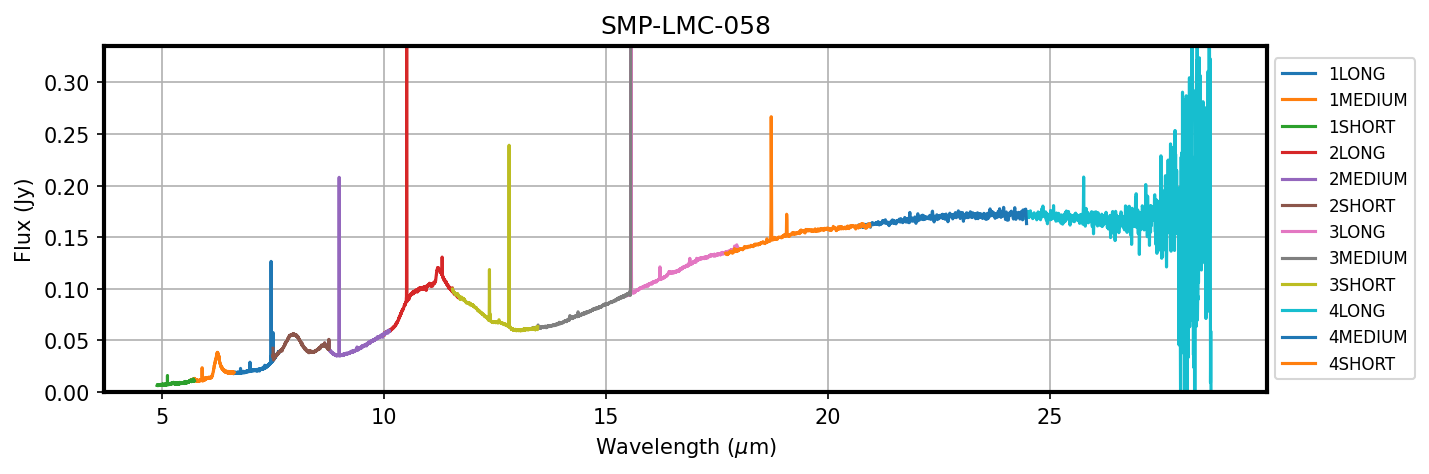

In [29]:
# Normal plots
%matplotlib inline
# Interactive plots
#%matplotlib notebook

rc('axes', linewidth=2)
fig, ax = plt.subplots(1,1, figsize=(10,3), dpi=150)

if (len(x1dfiles) > 0):
    hdu=fits.open(x1dfiles[0])
    objname=hdu[0].header['TARGPROP']
else:
    objname='Unknown'

ymin,ymax=np.nan,np.nan
for file in x1dfiles:
    x1d=fits.open(file)
    x1ddata=x1d[1].data
    wave=x1ddata['WAVELENGTH']
    flux=x1ddata['FLUX']
    ymin=np.nanmin([ymin,np.nanpercentile(flux,2)])
    ymax=np.nanmax([ymax,np.nanpercentile(flux,99.5)])
    
    # labels
    label=x1d[0].header['CHANNEL']+x1d[0].header['BAND']
    
    plt.plot(wave,flux,label=label)
    
plt.xlabel(r'Wavelength ($\mu$m)')
plt.ylabel('Flux (Jy)')
plt.title(objname)
plt.ylim(ymin,ymax)
plt.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://www.stsci.edu/~dlaw/stsci_logo.png" alt="stsci_logo" width="200px"/> 